#### Imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from photutils import aperture

Generate an object to get photometry for - you don't need this, this is just an example galaxy. 
You can do the same approach with anything, like saliency maps.

<b>Basically, replace this cell with your own data</b>

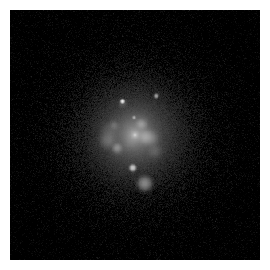

In [2]:
from galaxy_generator import (
    get_galaxy_rng_vals, simulate_perfect_galaxy, sky_noise
)

pxscale = 0.168
sky_mag = 23
seed = 8

# Generate the image
params = get_galaxy_rng_vals(1, perfect_pxscale=pxscale, seed=seed)[0]
img, galaxy_dict, r_pet = simulate_perfect_galaxy(pxscale=pxscale,  **params)
img, sky_flux = sky_noise(img, sky_mag, pxscale)

# Show the image
plt.imshow(-2.5*np.log10(np.abs(img)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
plt.axis('off');

The approach is:

1. Define the center of the image, `xc`, `yc`
2. Measure total flux (counts) in shells of thickness `dr` going from the center out to some `Rmax` (in pixels)

`dx` can be smaller than 15 pixels - I only picked a high value so that the shells are easy to see on the plot below :)

In [21]:
xc, yc = img.shape[1]/2, img.shape[0]/2          # Image center
Rmax = 0.5 * img.shape[0]/2                      # How far out do you want to go (right now, 0.5 x image size)
dr = 15                                           # Thickness of each shell, in pixels

Generate shells with inner radius $r_i$ and outer radius $r_i + dr$ and measure total flux in each shell:

In [22]:
# Note that I start with a radius 1e-3 rather than 0 here. This is because
# CircularAnnulus doesn't like setting r_in=0. You could instead use
# aperture.CircularAperture here not the Annulus but I was lazy to fix this edge case so I set r_in to a low number
r_ins = np.arange(1e-3, Rmax, dr)

fluxes = []
aps = []
for r_in in r_ins:
    # Make a shell
    ap = aperture.CircularAnnulus(positions=(xc,yc), r_in=r_in, r_out = r_in + dr)
    # Calculate the total flux in the shell and divide by shell area to get the average
    flux = ap.do_photometry(img)[0][0] / ap.area
    fluxes.append(flux)
    # Save the aperture to plot it
    aps.append(ap)

Plot the average flux as a function of radius from the center:

Text(0, 0.5, 'Average flux [counts]')

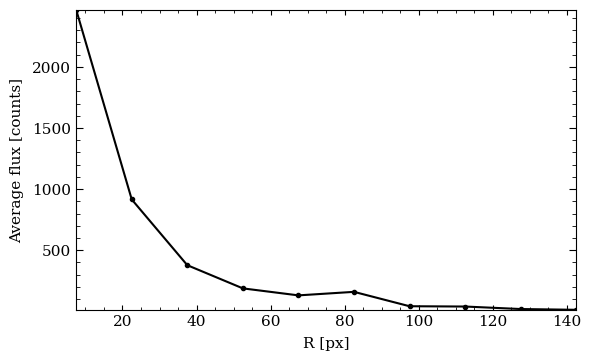

In [25]:
plt.figure(figsize=(5,3))
plt.plot(r_ins + dr/2, fluxes, 'k.-')
plt.xlabel('R [px]')
plt.ylabel('Average flux [counts]')

Plot the shells as well for your reference:

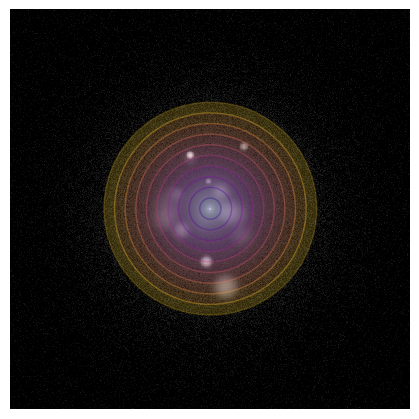

In [24]:
cmap = plt.get_cmap('plasma')
plt.figure(figsize=(4,4))
ax = plt.axes()
plt.imshow(-2.5*np.log10(np.abs(img)/pxscale**2) + 33, vmin=17, vmax=27, cmap='gray_r')
for idx, ap in enumerate(aps):
    # print(ap)
    ap.plot(ax, fill=True, color=cmap(idx/len(aps)), alpha=0.2, lw=1)
ax.axis('off');